Packages

In [68]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.transform import rescale, resize

In [2]:
#load in image
I= np.asarray(Image.open('test.jpg').convert("L"), dtype=float)
pikachu = np.asarray(Image.open('pikachu.jpg').convert("RGB"),dtype=int)
van_gogh = np.asarray(Image.open('van_gogh.jpg').convert("RGB"),dtype=int)

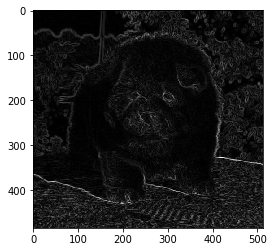

In [3]:
#Sobel Filter:
Gy = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Gx = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
m, n = Gx.shape
edge_x_img = np.zeros_like(I)
edge_y_img = np.zeros_like(I)
edge_img = np.zeros_like(I)

for i in range(I.shape[0] - m//2 * 2):
    for j in range(I.shape[1] - n//2 *2):
        edge_x_img[i+m//2,j+n//2] = sum(sum(np.multiply(I[i:i+m, j:j+n], Gx)))
        edge_y_img[i+m//2,j+n//2] = sum(sum(np.multiply(I[i:i+m, j:j+n], Gy)))
        edge_img[i+m//2, j+n//2] = np.sqrt(edge_x_img[i+m//2,j+n//2] ** 2 + edge_y_img[i+m//2,j+n//2] ** 2)

plt.imshow(edge_img, cmap="gray")

In [4]:
from skimage.exposure import cumulative_distribution
#source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
def cdf(im):
    c, b = cumulative_distribution(im) 
 # pad the beginning and ending pixels and their CDF values
    c = np.insert(c, 0, [0]*b[0])
    c = np.append(c, [1]*(255-b[-1]))
    return c

def hist_matching(c, c_t, im):
    pixels = np.arange(256)
 # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of   
 # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
    new_pixels = np.interp(c, c_t, pixels) 
    im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
    return im

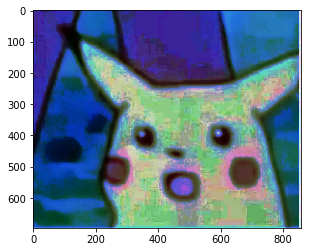

In [71]:
# red_output = hist_matching(cdf(pikachu[:,:,0]),cdf(van_gogh[:,:,0]),pikachu[:,:,0])
# green_output = hist_matching(cdf(pikachu[:,:,1]),cdf(van_gogh[:,:,1]),pikachu[:,:,1])
# blue_output = hist_matching(cdf(pikachu[:,:,2]),cdf(van_gogh[:,:,2]),pikachu[:,:,2])
# output = np.dstack((red_output,green_output,blue_output))
output = imhistmatch(pikachu, van_gogh)
plt.imshow(output)

In [65]:
# add noise
def add_noise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 100
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    return image + gauss

In [70]:
def imhistmatch(img1, img2):
    red_output = hist_matching(cdf(img1[:,:,0]),cdf(img2[:,:,0]),img1[:,:,0])
    green_output = hist_matching(cdf(img1[:,:,1]),cdf(img2[:,:,1]),img1[:,:,1])
    blue_output = hist_matching(cdf(img1[:,:,2]),cdf(img2[:,:,2]),img1[:,:,2])
    output = np.dstack((red_output,green_output,blue_output))
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


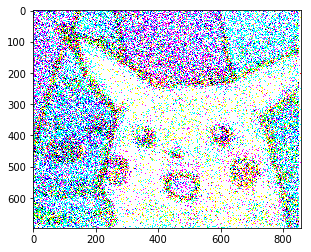

In [66]:
noisy_output = add_noise(output)
plt.imshow(noisy_output)

In [72]:
# content is already noised and im histed
def style_transfer(content, style, hall, mask, hallcoeff, Wcoeff, patch_sizes, scales, imsize):
    output_shape = (imsize, imsize, 3)
    C0 = imhistmatch(resize(content, output_shape),resize(style, output_shape))
    X = add_noise(C0)

    for L in scales:
        # scale the things!!!!!!
        content_scaled = rescale(content, 1/L)
        style_scaled = rescale(style, 1/L)
        mask = rescale(mask, 1/L)